In [1]:
# I load the needed libraries
library(dplyr)
library(scales)
library(GoFKernel)

library(mvtnorm)
library(gplots)
library(coda)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




# Test using a milti-dimensional gaussian with covariance

In order to have the most general form of the gaussian, I use the package "mvtnorm", standing for "Multivariate Normal and t Distributions", which allows me to create a gaussian in many dimension with a covariance on some axis

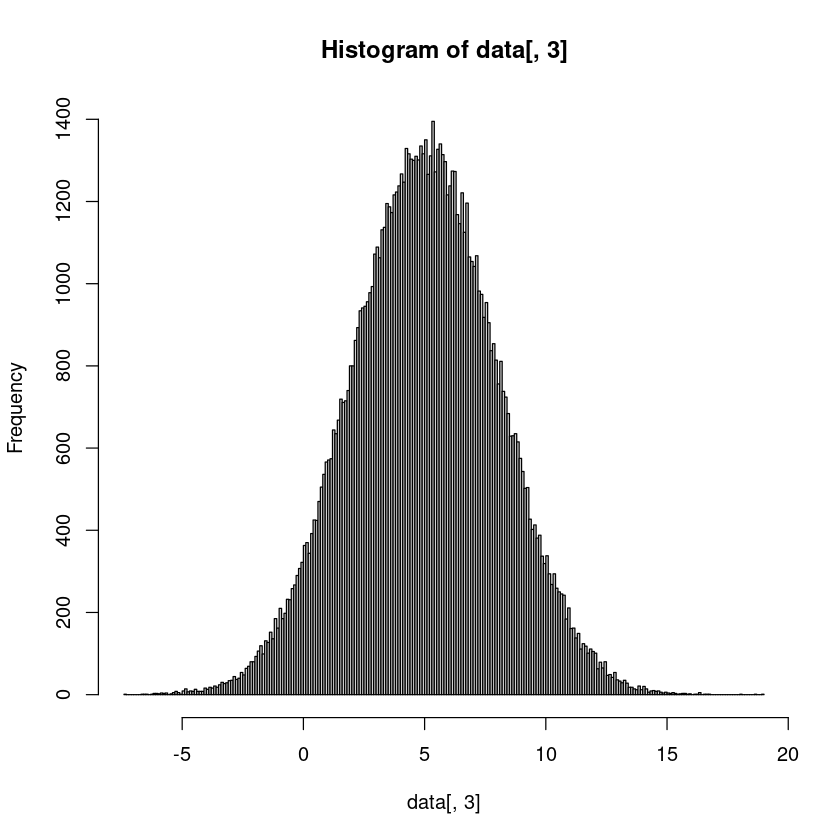


----------------------------
2-D Histogram Object
----------------------------

Call: hist2d(x = data[, -1], nbins = sqrt(length(data[, 1])), col = c("black", 
    heat.colors(12)), FUN = function(x) length(x))

Number of data points:  100000 
Number of grid bins:  317 x 317 
X range: ( -6.46439 , 13.52349 )
Y range: ( -7.371503 , 18.96358 )


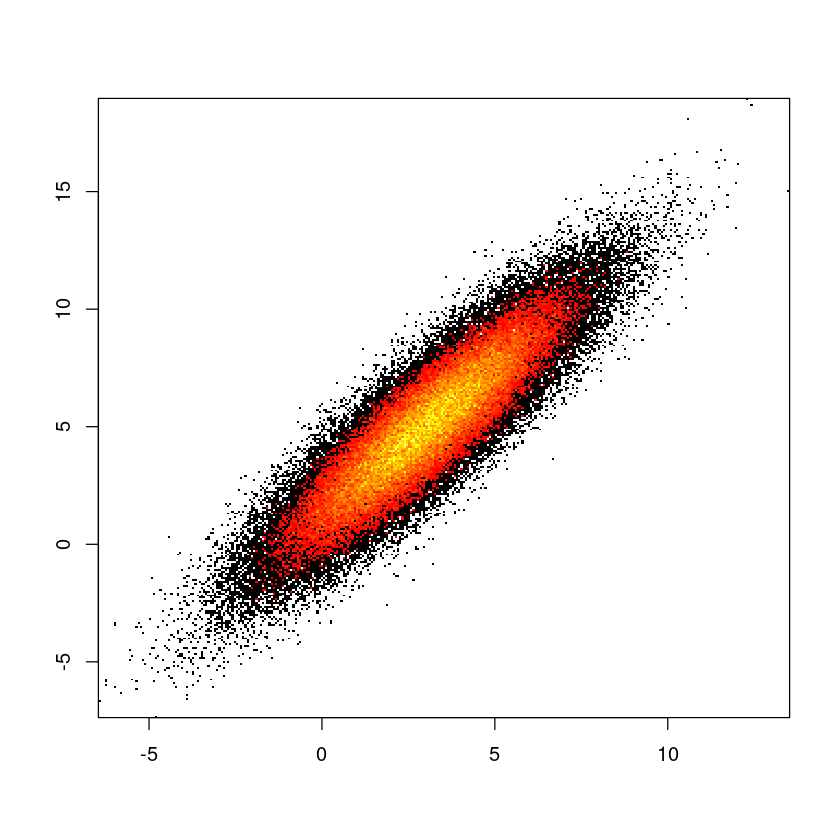

In [2]:
# Data for the check of the effectiveness of the package
cov = matrix(c(c(1, 2, 3), c(2, 5, 6), c(3, 6, 9)), ncol=3)
x0 = c(1, 3, 5)

# Function to be used is very similar to the one used for the one-dimensional gaussian
data = rmvnorm(1e5, mean = x0, sigma = cov, method = c("eigen", "svd", "chol"), pre0.9_9994 = FALSE, checkSymmetry = TRUE)

# I restrict the consistency on one of the dimentions in order to see if it really works on the mean 
hist(data[,3], breaks = sqrt(length(data[,1])))

# In order to check the covariance matrix, I plot the 2d histogram 
hist2d(data[,-1], nbins=sqrt(length(data[,1])), col=c("black", heat.colors(12)), FUN=function(x) length(x))



# MCMC using "mvtnorm" package

It is much faster than using the function that I implemented, and it allows to shape differently the multi-dimensional gaussian. It takes $\backsim 40$ seconds compared to the other that takes $\backsim 135$ seconds, more than three times its time. 

In [3]:
# Now I can change the function to generate the new data in the MCMC

# Then I create the function to extract the random number
generation_s = function (x0, cov) {

    # I use the library method to generate the new point
    new_value = rmvnorm(1, mean = x0, sigma = cov, method = c("eigen", "svd", "chol"), pre0.9_9994 = FALSE, checkSymmetry = FALSE)

    return(new_value)
}

# And the one to check the value of the quantiles
evaluate_Q = function(x0, cov, point) {

    # For the case of the normal distribution
    sx = dmvnorm(point, mean = x0, sigma = cov, log = FALSE)
    dx = dmvnorm(x0, mean = point, sigma = cov, log = FALSE)

    return(sx/dx)
}

# This function is ment to return the sequence of the samples for a determined function
random_steps = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = length(theta_init) + 1)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {

        # Take a guessed new theta (s in the slides) and evaluate its probability
        guessed_theta = generation_s(current_theta, sigma)
        guessed_function = func_wanted(guessed_theta)

        # Acceptance conditions
        Q_ratio = evaluate_Q(current_theta, sigma, guessed_theta)
        rho = guessed_function/current_function * Q_ratio
        # cat(guessed_theta, guessed_function, Q_ratio, rho)

        # And then update the general conditions
        if (rho > runif(1)) {
            current_theta = guessed_theta
            current_function = guessed_function
            accepted = accepted + 1
        } # else they remain unchanged and then loaded direcctly in the solutions vector

        # Saving the generated samples because R doesn't accept two elements in returns
        samples[n,] = unlist(c(current_function, current_theta))

    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/n_samples*100, 5), '%\n')
    }

    return(samples)
}


In [4]:
# Function to sampled from: n-dim gaussian with chosen sigmas and centers
posterior_g_inhom = function (theta) {

    sigmas = c(1:length(theta))
    centers = c(seq(length(theta), 1))

    product = 1
    for (i in 1:length(theta)) {
        product = product * exp(-(theta[i] - centers[i])**2/sigmas[i]**2)
    }

    return (product)

}

# The initial parameters are:
init = c(1, 2, 3)
std = diag(1, 3)
burn_in = 0
N = as.integer(1e5) + burn_in

# Evaluate then the MCMC
mcmc_g = random_steps(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N, sigma = std, print_accept=TRUE)

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N, ]


Acceptance rate =  49.774 %


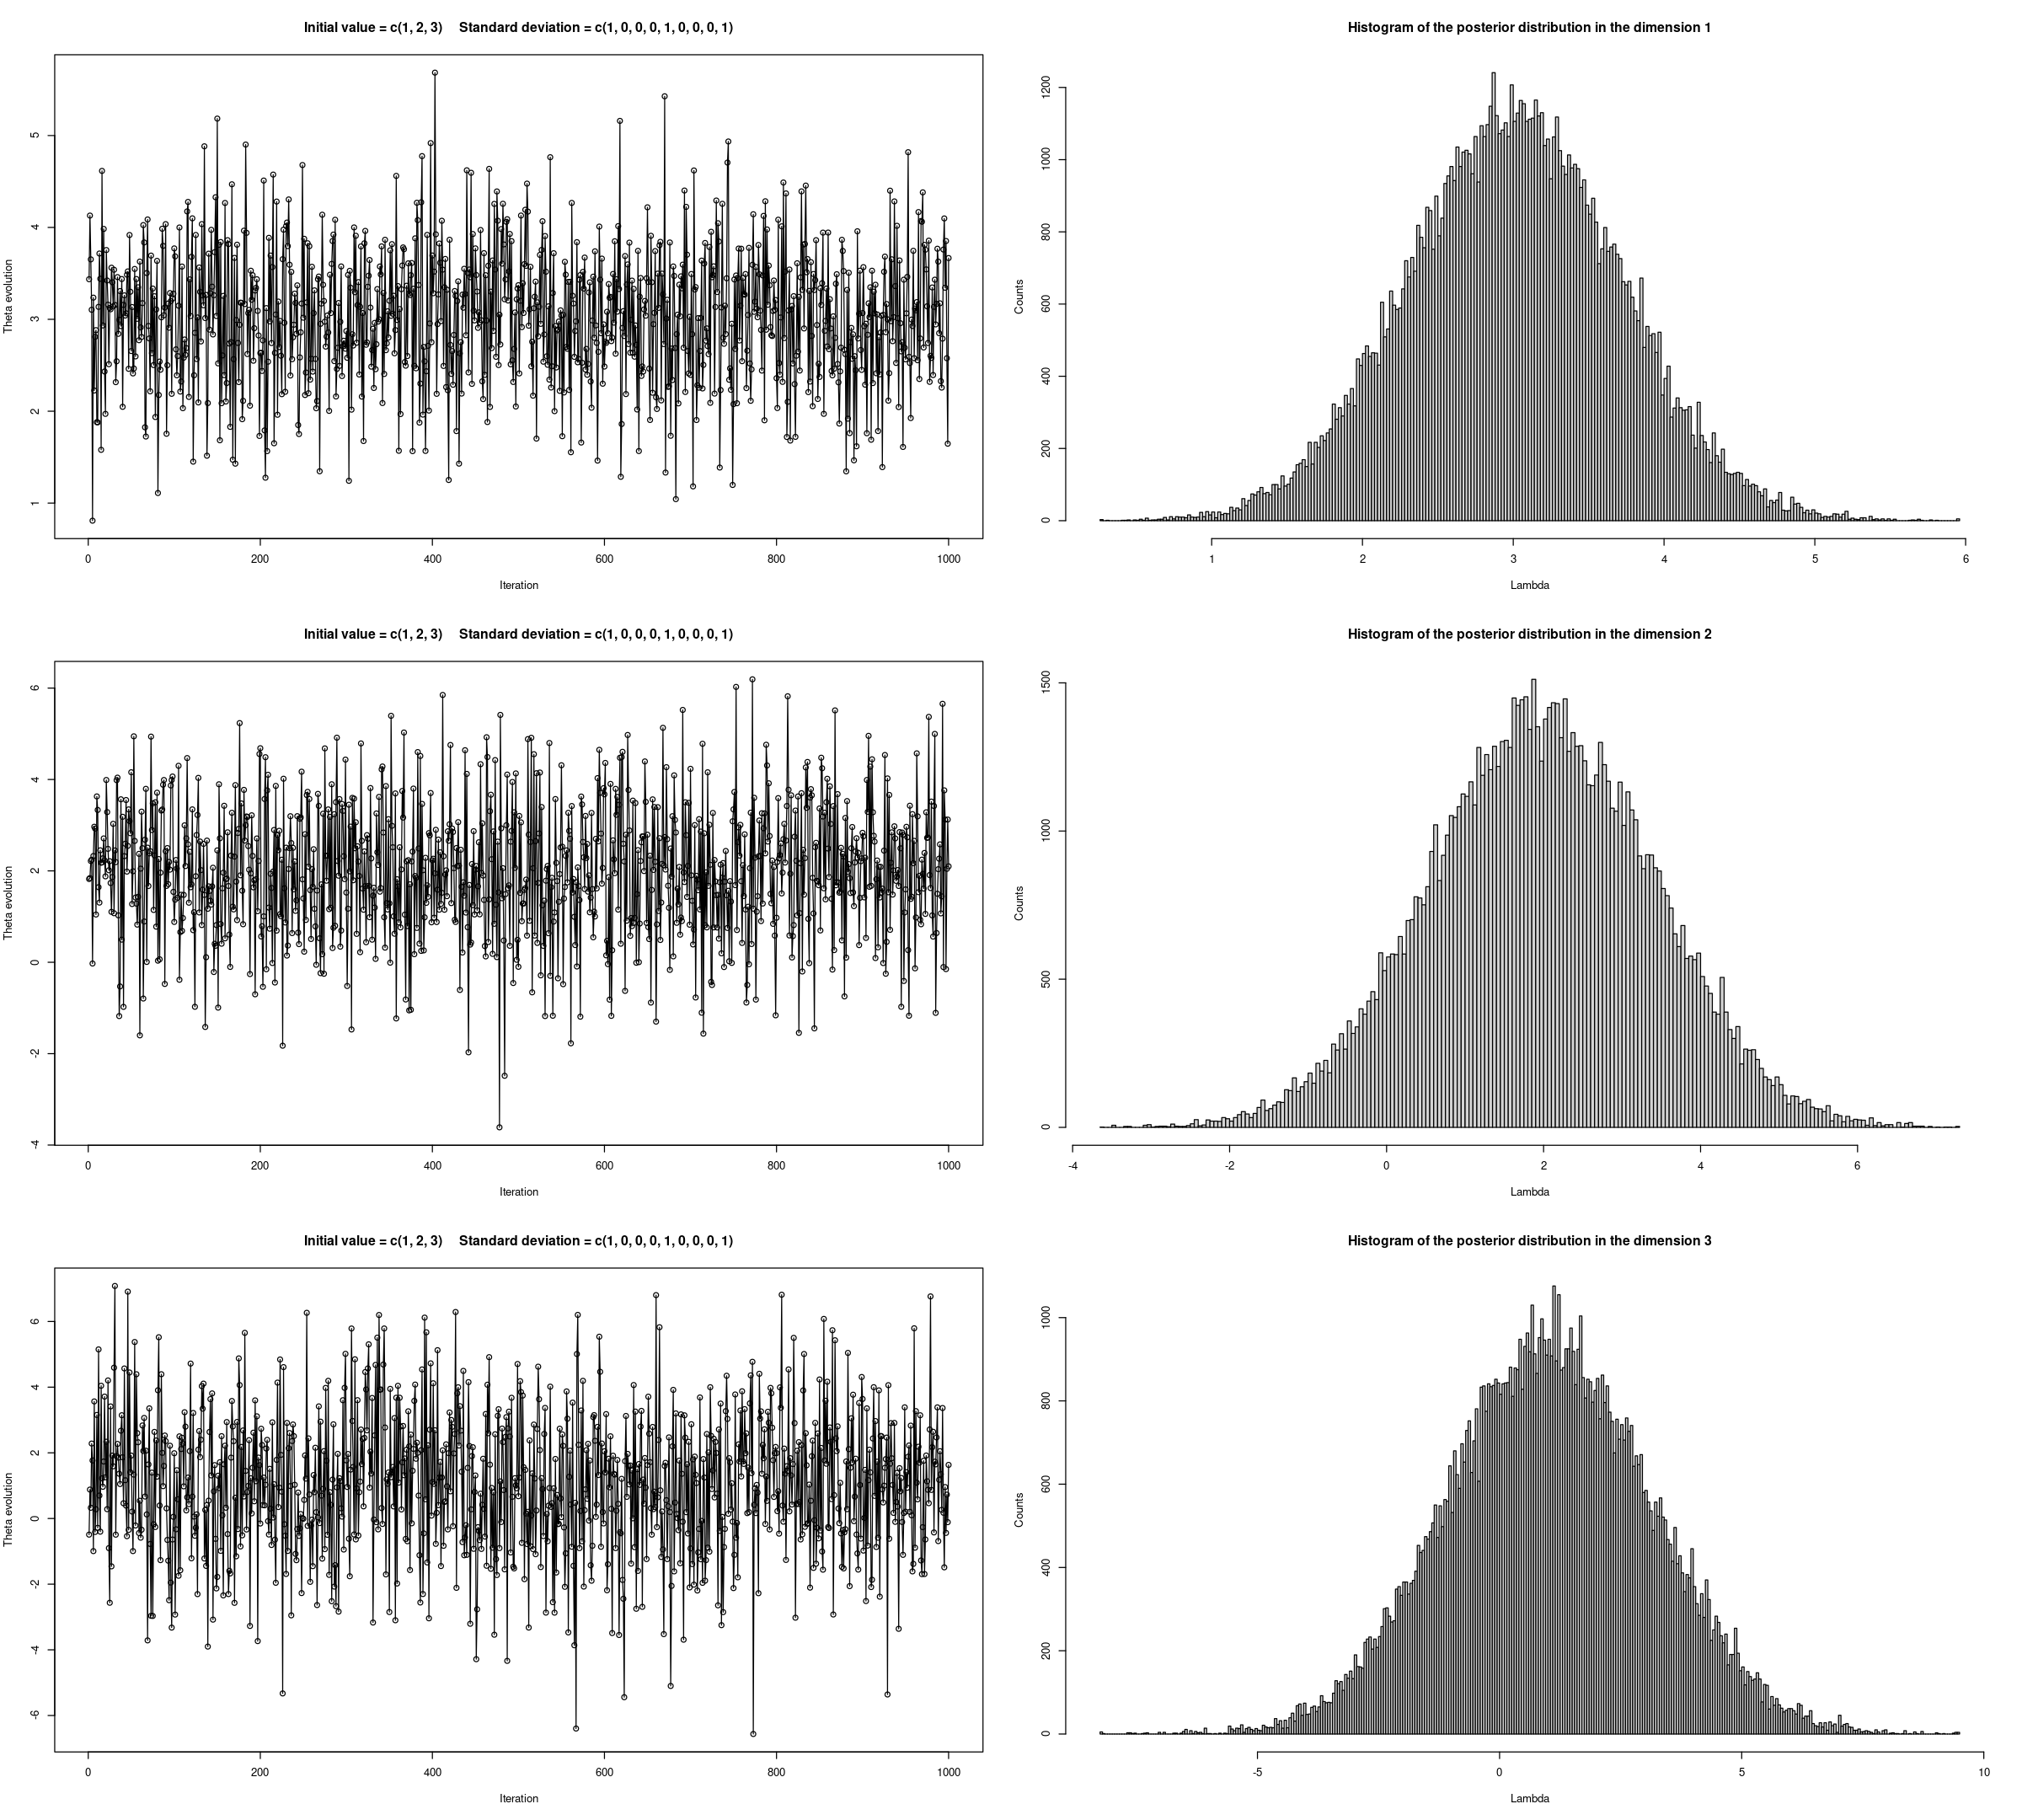

In [5]:
# Printing then the evolution of the chain and the resulting distribution
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

# Plotting every dimension of the plot
par(mfrow=c(lungh-1, 2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), dim]
    plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', 
        main = paste0('Initial value = ', list(init), '     Standard deviation = ', list(std)))
    hist(mcmc_g[,dim], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts',
        main = paste('Histogram of the posterior distribution in the dimension', dim-1))
}


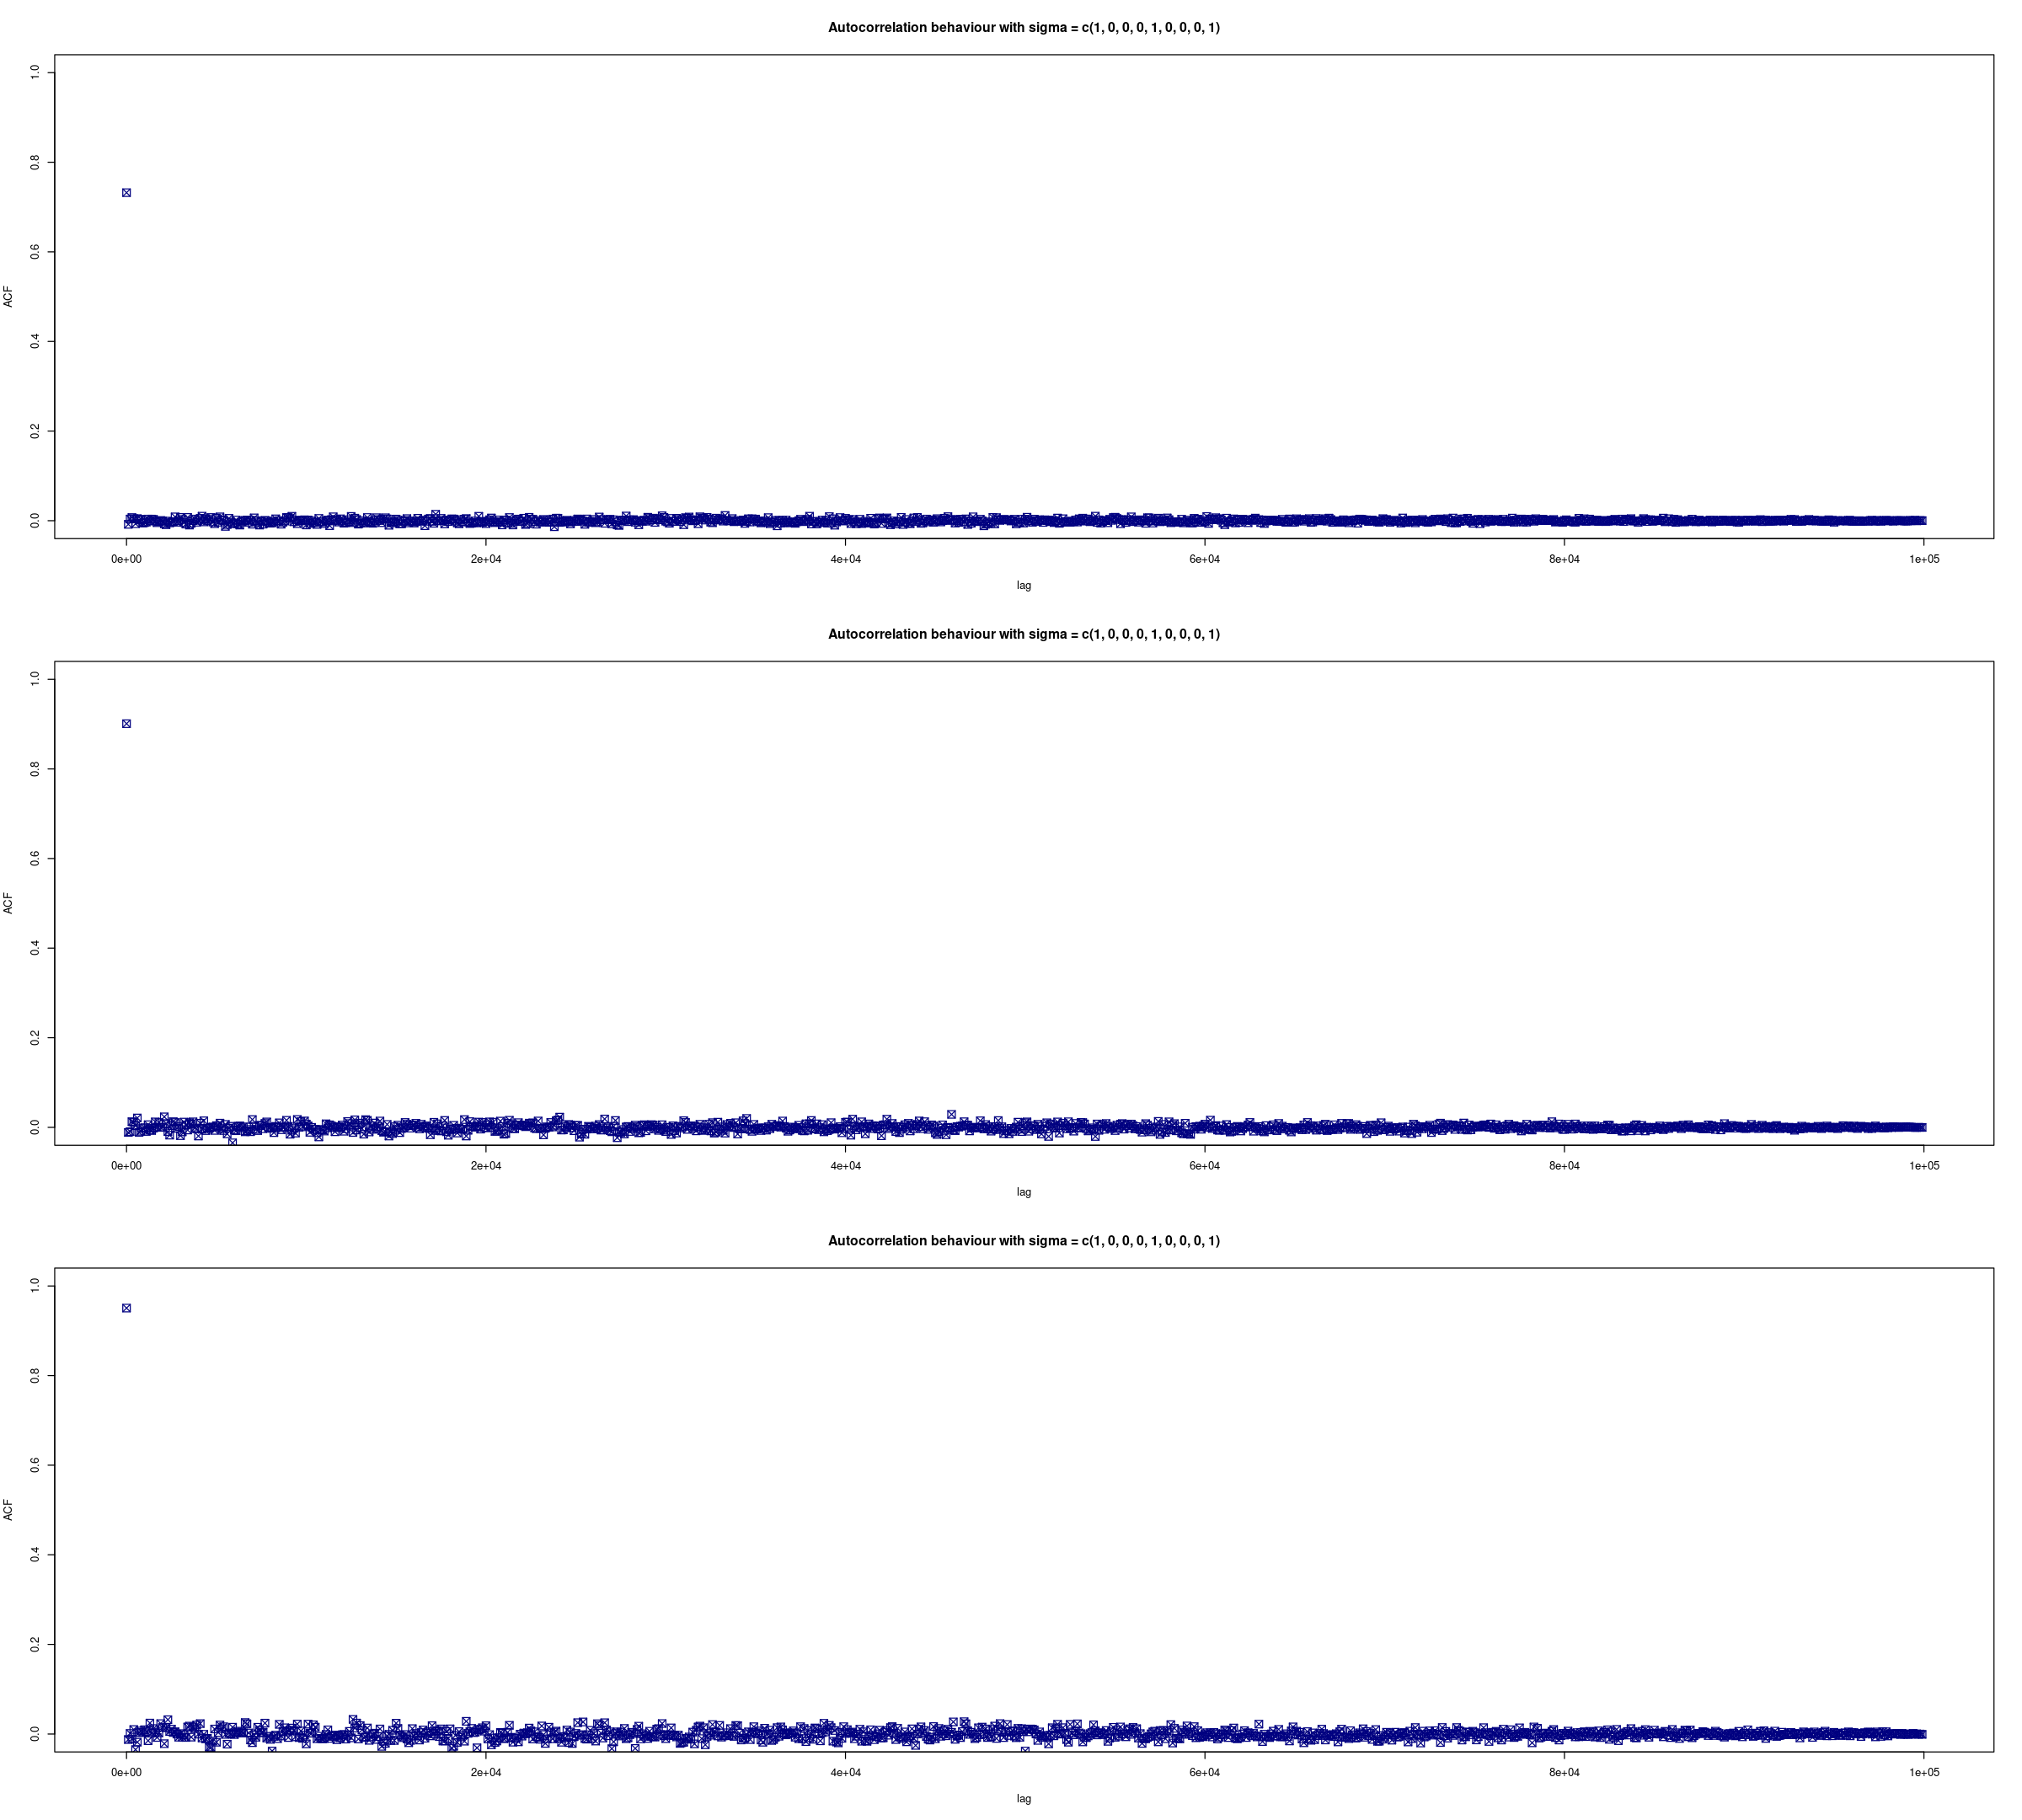

In [6]:
lungh = as.integer(length(mcmc_g[1,]))
step = 1e3

par(mfrow=c(lungh-1, 1), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # I ensure that this is now a MCMC
    g_chain = as.mcmc(mcmc_g[,dim])

    # Then I check the autocorrelation using CODA
    lags = seq(1,N,step)
    auto_g = autocorr(g_chain, lags=lags)

    # And finally I plot the autocorrelation evolution:
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))
}


In [7]:
mcmc_copy = mcmc_g


# MCMC using "mvtnorm" package + Gibbs Sampling

I only add the possibility of moving along each parameter dimension instead of jumping in all the dimentions at once, in order to see if there would be an improvement also in the mvtnorm implementation

In [8]:
# Now I can change the function to generate the new data in the MCMC

# Then I create the function to extract the random number
generation_s_gibbs = function (x0, cov) {

    # I use the library method to generate the new point
    new_value = rmvnorm(1, mean = x0, sigma = cov, method = c("eigen", "svd", "chol"), pre0.9_9994 = FALSE, checkSymmetry = FALSE)

    return(new_value)
}

# And the one to check the value of the quantiles
evaluate_Q_gibbs = function(x0, cov, point) {

    # For the case of the normal distribution
    sx = dmvnorm(point, mean = x0, sigma = cov, log = FALSE)
    dx = dmvnorm(x0, mean = point, sigma = cov, log = FALSE)

    return(sx/dx)
}

# This function is ment to return the sequence of the samples for a determined function
random_steps_gibbs = function (func_wanted, theta_init, n_samples, sigma, print_accept=FALSE) {

    # Initilalizing the parameters
    current_theta = theta_init
    current_function = func_wanted(theta_init)
    dimensions = length(theta_init)
    samples = matrix(data = NA, nrow = n_samples, ncol = length(theta_init) + 1)

    # For statistical purposes
    accepted = 0

    # Evolution loop
    for (n in 1:n_samples) {

        guessed_theta = current_theta

        # I then can loop on the dimensions of the distribution to allpy the gibbs sampling
        for (dim in 1:dimensions) {

            # Take a guessed new theta (s in the slides) and evaluate its probability
            guessed_theta[dim] = generation_s_gibbs(current_theta, sigma)[dim]
            guessed_function = func_wanted(guessed_theta)

            # Acceptance conditions
            Q_ratio = evaluate_Q_gibbs(current_theta, sigma, guessed_theta)
            rho = guessed_function/current_function * Q_ratio
            # cat(guessed_theta, guessed_function, Q_ratio, rho)

            # And then update the general conditions
            if (rho > runif(1)) {
                current_theta[dim] = guessed_theta[dim]
                current_function = guessed_function
                accepted = accepted + 1
            } # else they remain unchanged and then loaded direcctly in the solutions vector
        
        }

        # Saving the generated samples because R doesn't accept two elements in returns
        samples[n,] = unlist(c(current_function, current_theta))

    }

    if(print_accept) {
        cat("Acceptance rate = ", round(accepted/(n_samples*dimensions)*100, 5), '%\n')
    }

    return(samples)
}


In [9]:
# Function to sampled from: n-dim gaussian with chosen sigmas and centers
posterior_g_inhom = function (theta) {

    sigmas = c(1:length(theta))
    centers = c(seq(length(theta), 1))

    product = 1
    for (i in 1:length(theta)) {
        product = product * exp(-(theta[i] - centers[i])**2/sigmas[i]**2)
    }

    return (product)

}

# The initial parameters are:
init = c(1, 2, 3)
std = diag(1, 3)
burn_in = 0
N = as.integer(1e5) + burn_in

# Evaluate then the MCMC
mcmc_g = random_steps_gibbs(func_wanted = posterior_g_inhom, theta_init = init, n_samples = N, sigma = std, print_accept=TRUE)

# Selecting the sequence after the burn-in
mcmc_g = mcmc_g[burn_in:N, ]


Acceptance rate =  60.20433 %


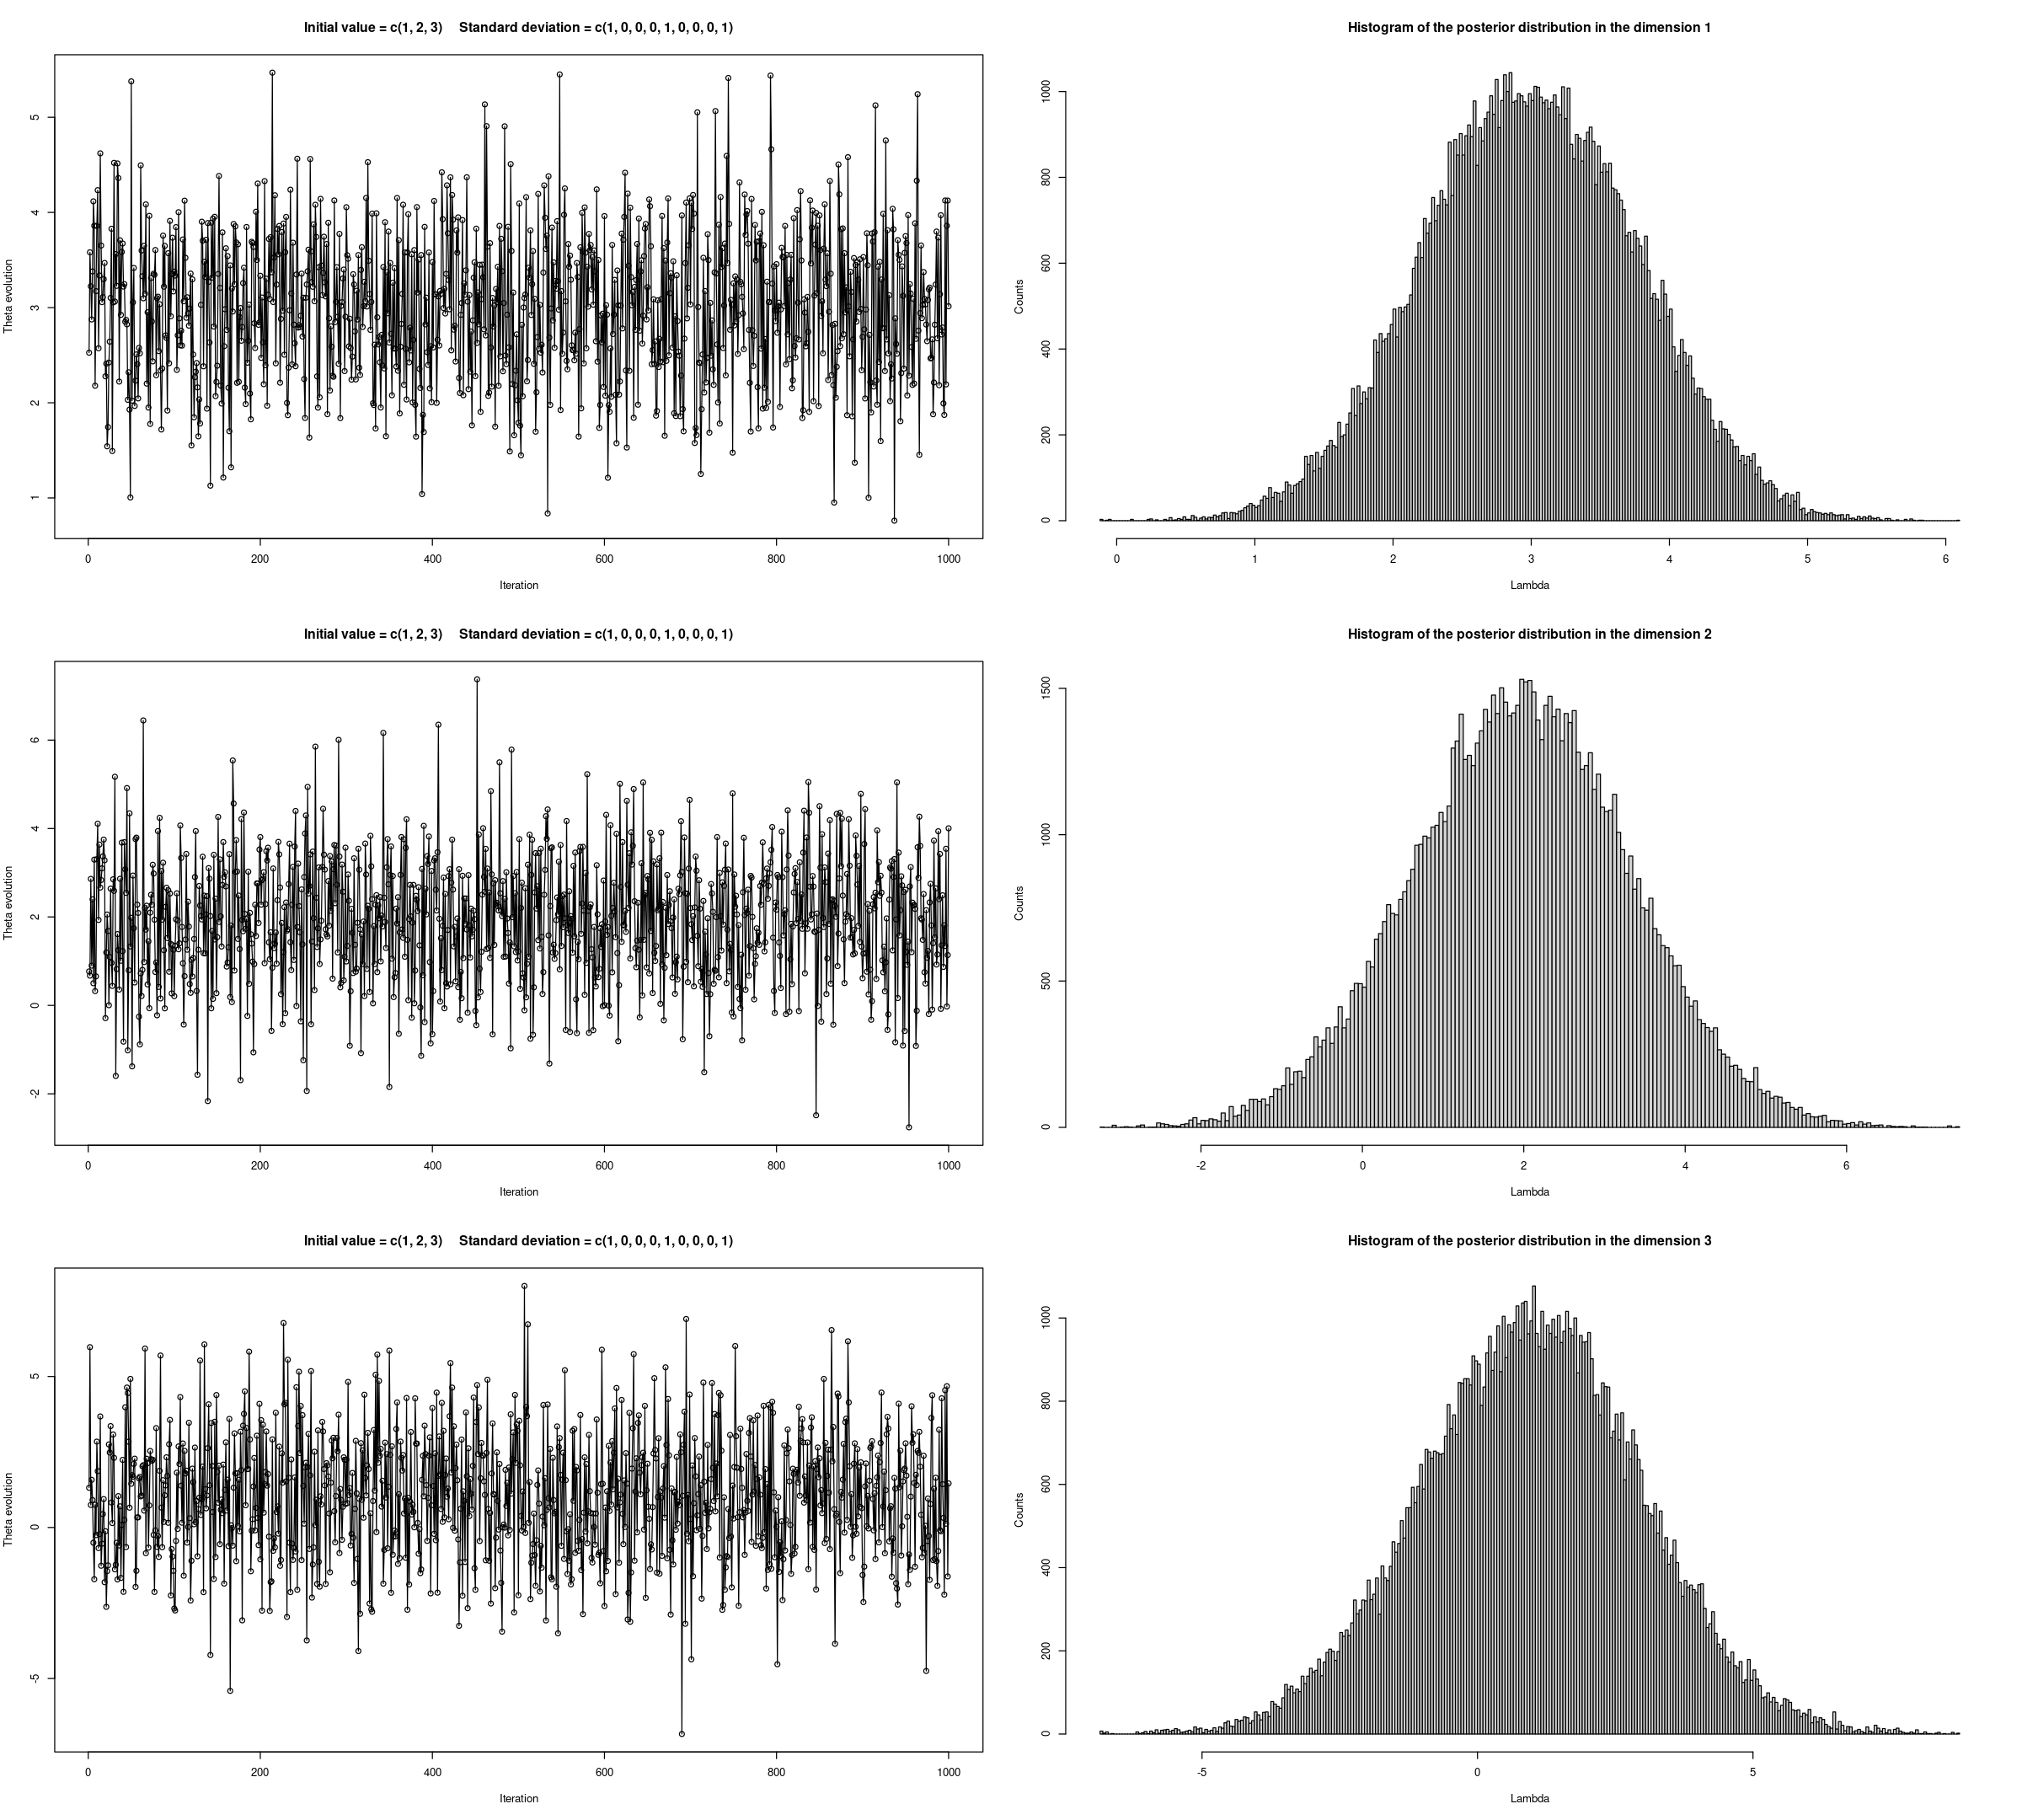

In [10]:
# Printing then the evolution of the chain and the resulting distribution
lungh = as.integer(length(mcmc_g[1,]))
step = 1e2

# Plotting every dimension of the plot
par(mfrow=c(lungh-1, 2), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    plot_g = mcmc_g[seq(0, length(mcmc_g[,1]), step), dim]
    plot(1:length(plot_g), plot_g, type = 'o', lwd = 1, col = 'black', xlab = 'Iteration', ylab = 'Theta evolution', 
        main = paste0('Initial value = ', list(init), '     Standard deviation = ', list(std)))
    hist(mcmc_g[,dim], breaks = as.integer(sqrt(length(mcmc_g[,1]))), xlab = 'Lambda', ylab = 'Counts',
        main = paste('Histogram of the posterior distribution in the dimension', dim-1))
}


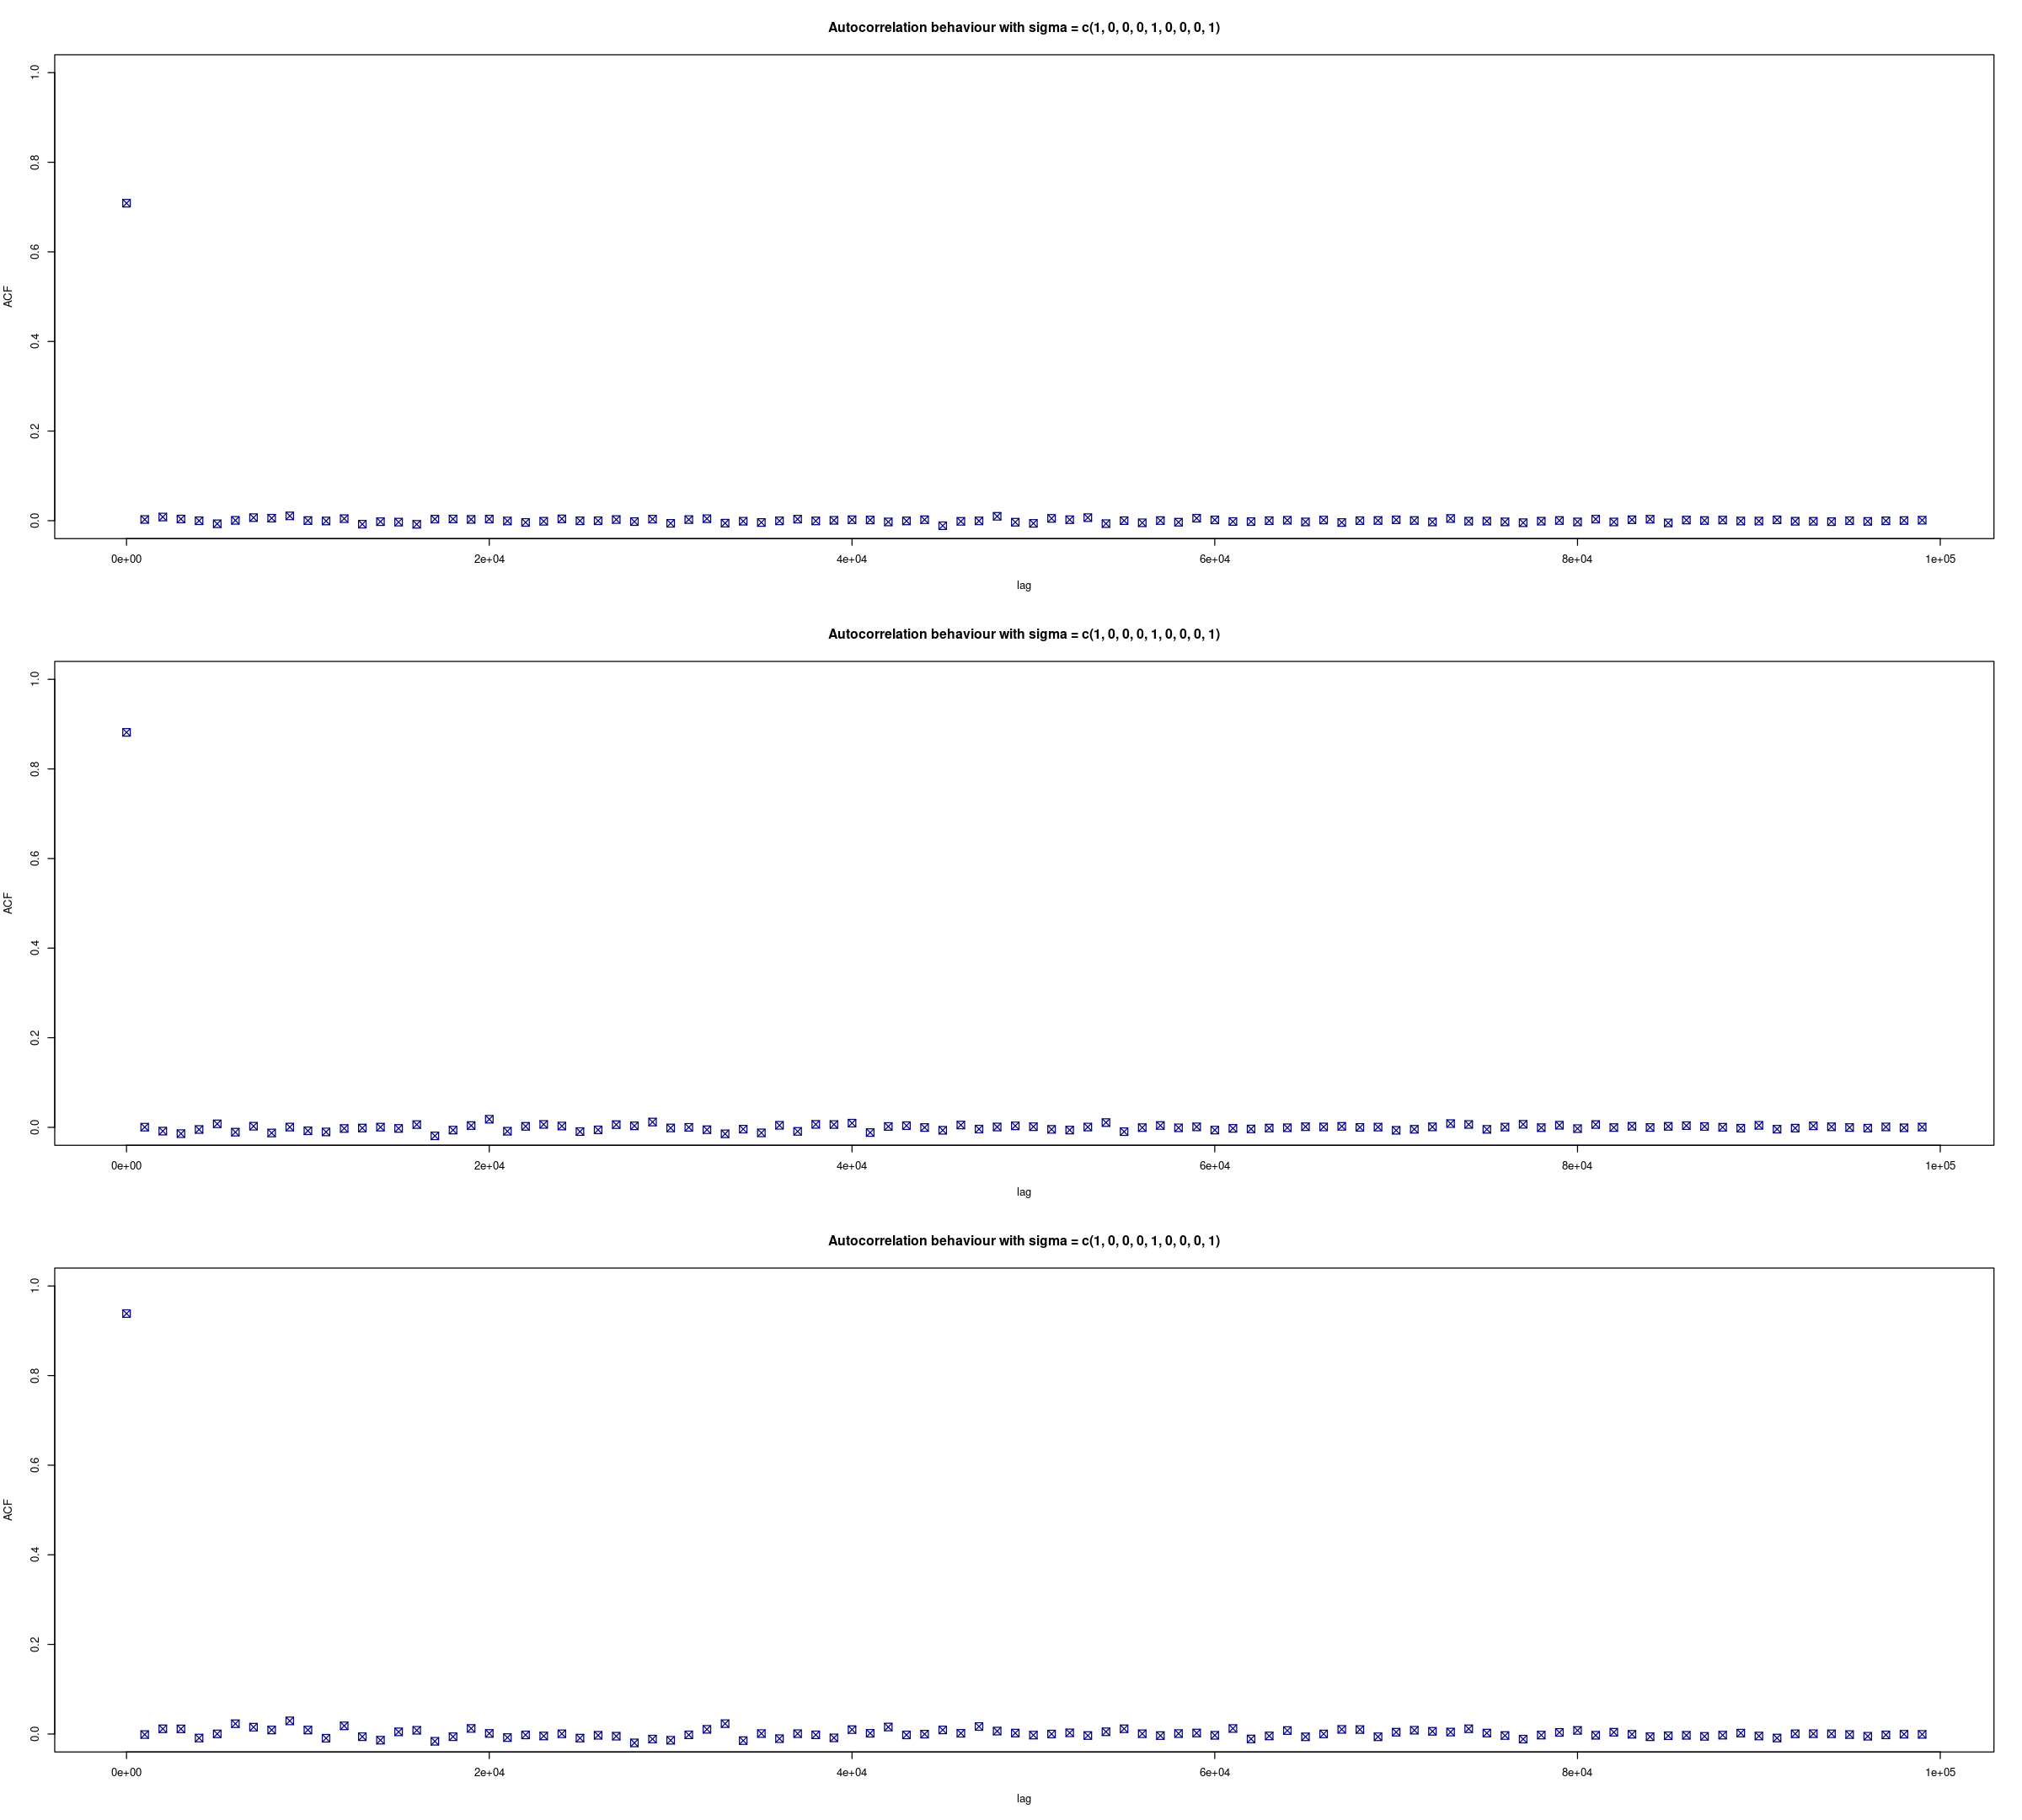

In [11]:
lungh = as.integer(length(mcmc_g[1,]))
step = 1e3

par(mfrow=c(lungh-1, 1), oma = c(0, 0, 0, 0))
options(repr.plot.width=20, repr.plot.height=6*(lungh-1))

for (dim in 2:lungh) {
    # I ensure that this is now a MCMC
    g_chain = as.mcmc(mcmc_g[,dim])

    # Then I check the autocorrelation using CODA
    lags = seq(1,N,step)
    auto_g = autocorr(g_chain, lags=lags)

    # And finally I plot the autocorrelation evolution:
    plot(lags, auto_g, ylim=c(0,1), pch=7, col="navy", xlab="lag", ylab="ACF", cex=1.5, main = paste("Autocorrelation behaviour with sigma =", list(std)))
}


# Results and performancies: 

I use a table in order to present the results:

| Function              | Acceptance Rate (%) | Time needed (s) | Coda Autocorrelation  |
|---                    |---                  |---              |---                    |
| 1D MCMC               | 60                  | 30              | low                   |
| 3D MCMC Metropolis    | 48                  | 130             | low                   |
| 3D MCMC Gibbs         | 59                  | 135             | low                   |
| 3D MCMC mvtnorm       | 50                  | 40              | low                   |
| 3D MCMC mvtnorm Gibbs | 57                  | 140             | low                   |

These results have been retrieved running the program three times with different initial points looking for a total of 100_000 points using a very wide gaussian for the sampling (unchanged) in order to present the strenghts and weakness of the three methods.

- 1D is very performing, but has the limit of the dimensions

- 3D Metropolis has a low acceptance rate: the gaussian for the selection of the new point is very wide, resulting in a small acceptance rate
- 3D Gibbs returns to the higher acceptance rate found in the 1D case (since it moves in 1D)

- 3D mvtnorm gives the possibility of having covariance, but at the cost of time speed and acceptance rate (it is done without Gibbs sampling, in order to spare time and computational resources, otherwise they would scale linearly with the number of dimentions)
- 3D mvtnorm Gibbs, as done in the previous case, increases the acceptance rate at the cost of time

All of them have a low Autocorrelation due to the very wide sampling ditribution, but unluckily all of them suffer from the same problem: no covariance in the selecting distribution. We want an algorithm that keeps the autocorrelation low, but increases the acceptance rate, shaping the sampling distribution at will in order to archieve these goals

#### Attention: I cannot use these algorithms for ADAPTIVE MCMC, because they don't allow to shape properly the multi-dimensional gaussian, therefore I need an algorithm that uses directly the covariance matrix